# Extraction of diffraction peaks from diffuse background

This example works by weighing the area under a
peak with positive values and surrounding the peak with a ring of
negative weight pixels in such a way that the total sum is 0. Applying
this mask to a constant background consequently yields 0, and only
differences between spot and surrounding ring show up in the result as
positive or negative values.

Sample data courtesy of Ian MacLaren <Ian.MacLaren@glasgow.ac.uk> and
Shane McCartan <s.mccartan.1@research.gla.ac.uk>, University of Glasgow

Sample preparation: David Hall and Ilkan Calisir

The dataset is from a solid solution ceramic of bismuth ferrite and barium 
titanate (ratio: 75%/25%) doped 3% Ti. Chemical segregation of the bismuth 
ferrite and barium titanate occurs in the formation of the core-shell type 
structure that you can see in the grain (barium titanate-shell, bismuth 
ferrite-core). The grain is orientated along the [110] direction as the 
extra spots that BFO produces at the 1/2 (111) positions are obvious in 
this orientation. Otherwise the diffraction patterns of BFO and BTO are 
too similar to distinguish easily.

## Set up the environment and import libraries

We disable threading in any numerics libraries because we already saturate the CPU with multiprocessing. Additional threads would get in each other's way and slow things down rather than speed them up. The environment variables have to be set as early as possible before any of the libraries are loaded.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from libertem import api
# Prototype code in branch "phase-correlation-proto"
# FIXME update to production version as soon as it is done
import libertem.udf.blobfinder as blobfinder
import libertem.analysis.gridmatching as grm

## Create LiberTEM Context
Start a local cluster (default) or connect to a running cluster (TODO: To be implemented).

A warning about port 8787 being already in use can be ignored, that's only for cluster diagnostics.

In [6]:
ctx = api.Context()

## Load file
The parameters depend on the data set type. We can get basic information about the file from the dataset, for example its dimensions.

In [7]:
ds = ctx.load(
    "blo",
    path='C:/Users/weber/Nextcloud/Projects/Open Pixelated STEM framework/Data/3rd-party Datasets/Glasgow/10 um 110.blo',
    tileshape=(1,8,144,144)
)

In [9]:
parameters = {
    'mask_type': 'background_substraction',
    'radius': 2,
    'radius_outer': 3,
    'padding': 0.5,
    'num_disks': 70
}

result = blobfinder.run_blobfinder(ctx, ds, parameters)

(144, 144)
(90, 121, 70, 2)
(90, 121, 70)
(90, 121, 70)
(70, 2)


<IPython.core.display.Javascript object>


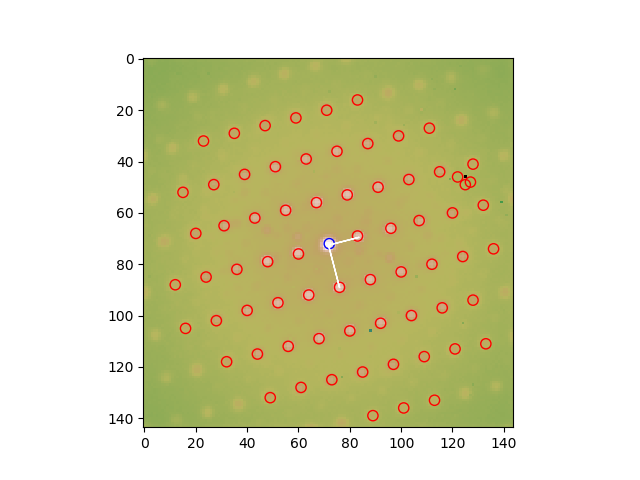

[72.56524431 71.70095812] [16.61878223  4.32182447] [-3.06980345 11.99123791] 67
4 0


In [12]:
sum_result, centers, refined, peak_values, peak_elevations, peaks = result
print(sum_result.shape)
print(centers.data.shape)
print(peak_values.data.shape)
print(peak_elevations.data.shape)
print(peaks.shape)

zero = peaks[0]

fig, axes = plt.subplots()
axes.imshow(sum_result, cmap=cm.gist_earth)
axes.add_artist(plt.Circle(np.flip(zero), parameters['radius'], color="b", fill=False))
for p in np.flip(peaks[1:], axis=1):
    axes.add_artist(plt.Circle(p, parameters['radius'], color="r", fill=False))

# Limits for connecting vector length to be considered a base vector candidate
params = {
    'min_delta': 1,
    'max_delta': 20,
    'tolerance': 0.01,
    'min_cluster_size_fraction': 10,
    'min_samples_fraction': 10,
    'min_angle': np.pi/5,
    'num_candidates': 7,
    'min_weight': 0.3,
}

candidates = [
    (16.5, 4.33),
    (-3.05, 11.93)
]

global_correlation = grm.CorrelationResult(
    centers=peaks, refineds=peaks, 
    peak_values=np.ones(len(peaks)), 
    peak_elevations=np.ones(len(peaks)))

(matches, unmatched, weak) = grm.Match.full_match(correlation_result=global_correlation, zero=zero, cand=candidates, parameters=params)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']


for m in matches:
    color = colors.pop()
    print(m.zero, m.a, m.b, len(m))
    plt.arrow(*np.flip(m.zero), *(np.flip(m.a)), color=color)
    plt.arrow(*np.flip(m.zero), *(np.flip(m.b)), color=color)

print(len(unmatched), len(weak))

#match_zero, a, b, matched, indices, weights = matches[0]

<IPython.core.display.Javascript object>


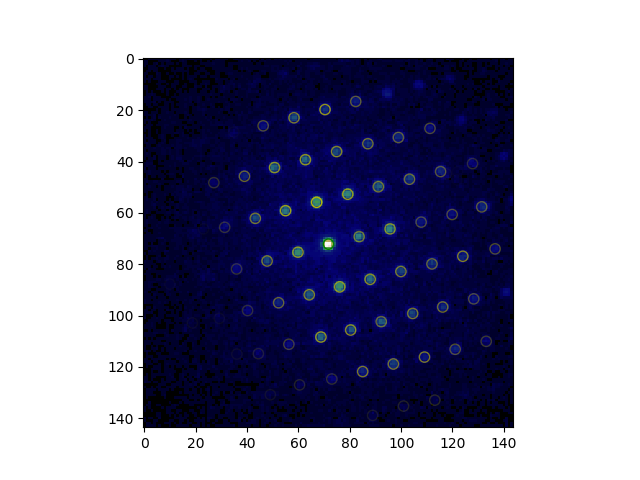

In [17]:
y = 48
x = 38

get_sample_frame = ctx.create_pick_analysis(dataset=ds, y=y, x=x)
sample_frame = ctx.run(get_sample_frame)

fig, axes = plt.subplots()
axes.imshow(sample_frame[0].raw_data, cmap=cm.gist_earth)

sample_fit = centers.data[y, x]

sample_zero = sample_fit[0]

sample_refined_fit = refined.data[y, x]

sample_refined_zero = sample_refined_fit[0]

sample_elevations = peak_elevations.data[y, x]

max_elevation = np.max(sample_elevations)


#axes.add_artist(plt.Circle(sample_zero, parameters['radius'], color="b", fill=False))
#for p in sample_fit[1:]:
#    axes.add_artist(plt.Circle(p, parameters['radius'], color="r", fill=False))

axes.add_artist(plt.Circle(np.flip(sample_refined_zero), parameters['radius'], color="g", fill=False))
for i in range(1, len(sample_refined_fit)):
    p = np.flip(sample_refined_fit[i])
    a = max(0, sample_elevations[i] / max_elevation)
    axes.add_artist(plt.Circle(p, parameters['radius'], color="y", fill=False, alpha=a))

<IPython.core.display.Javascript object>


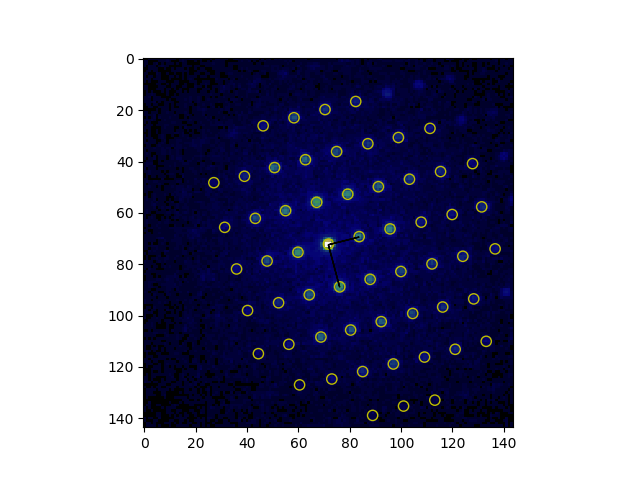

[72.41853189 71.63755234] [16.52387873  4.4169203 ] [-3.01251502 12.01204201] 57


In [13]:
y = 48
x = 38

get_sample_frame = ctx.create_pick_analysis(dataset=ds, y=y, x=x)
sample_frame = ctx.run(get_sample_frame)

fig, axes = plt.subplots()
axes.imshow(sample_frame[0].raw_data, cmap=cm.gist_earth)

sample_fit = centers.data[y, x]

sample_zero = sample_fit[0]

sample_refined_fit = refined.data[y, x]

sample_refined_zero = sample_refined_fit[0]

sample_elevations = peak_elevations.data[y, x]

correlation_result = grm.CorrelationResult(
    centers=centers.data[y, x], 
    refineds=refined.data[y, x], 
    peak_values=peak_values.data[y, x], 
    peak_elevations = peak_elevations.data[y, x]
)

#axes.add_artist(plt.Circle(sample_zero, parameters['radius'], color="b", fill=False))
#for p in sample_fit[1:]:
#    axes.add_artist(plt.Circle(p, parameters['radius'], color="r", fill=False))

#axes.add_artist(plt.Circle(sample_refined_zero, parameters['radius'], color="g", fill=False))
#for p in sample_refined_fit[1:]:
#    axes.add_artist(plt.Circle(p, parameters['radius'], color="g", fill=False))
    
match = grm.Match.fastmatch(correlation_result=correlation_result, 
                            zero=matches[0].zero, a=matches[0].a, b=matches[0].b, parameters=params)

for p in match.refineds:
    axes.add_artist(plt.Circle(np.flip(p), parameters['radius'], color="y", fill=False))



print(match.zero, match.a, match.b, len(match))
axes.arrow(*np.flip(match.zero), *(np.flip(match.a)))
axes.arrow(*np.flip(match.zero), *(np.flip(match.b)))

    

In [15]:
(i, j, l, k) = refined.data.shape

res = [
    [
        grm.Match.fastmatch(
            correlation_result=grm.CorrelationResult(
                centers = centers.data[ii, jj],
                refineds=refined.data[ii, jj], 
                peak_values=peak_values.data[ii, jj],
                peak_elevations=peak_elevations.data[ii, jj]
            ),
            zero=matches[0].zero,
            a=matches[0].a,
            b=matches[0].b,
            parameters=params
        ) for jj in range(j)
    ] 
    for ii in range(i)
]

c:\users\weber\documents\libertem\libertem\src\libertem\analysis\gridmatching.py:200: RuntimeWarning: invalid value encountered in greater_equal
  filt = correlation_result.peak_elevations >= p['min_weight']


<IPython.core.display.Javascript object>


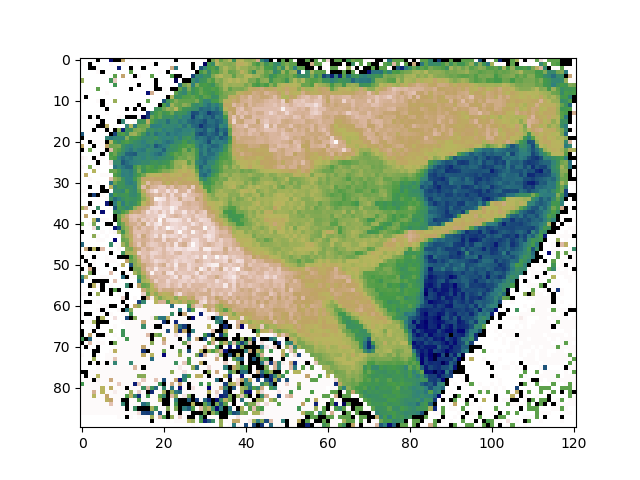

In [16]:
zeros = np.array([[r.zero for r in l] for l in res])
aas = np.array([[r.a for r in l] for l in res])
bbs = np.array([[r.b for r in l] for l in res])

folded_shape = aas.shape

flat_shape = (folded_shape[0] * folded_shape[1], folded_shape[2])

polar_aas = grm.make_polar(aas.reshape(flat_shape)).reshape(folded_shape)
polar_bbs = grm.make_polar(bbs.reshape(flat_shape)).reshape(folded_shape)

angle_difference = polar_aas[:,:,1] - polar_bbs[:,:,1]
length_ratio = polar_aas[:,:,0] / polar_bbs[:,:,0]
volume = polar_aas[:,:,0] * polar_bbs[:,:,0]

#polar_bbs = np.array([[r[2] for r in l] for l in res])

dots = np.array([[np.dot(aas[l, i], bbs[l, i]) for i in range(len(aas[0]))] for l in range(len(aas))])

counts = np.array([[len(r) for r in l] for l in res])

fig, axes = plt.subplots()
axes.imshow(dots, cmap=cm.gist_earth, vmin=-4, vmax=4)